In [15]:
import numpy as np
import matplotlib.pyplot as plt

import numpy.polynomial.polynomial as poly
import astropy
from   astropy.io import fits as pyfits
import csv
import sys
import os
from   timeit import default_timer as timer
import warnings
import corner

from alderaan.constants import *
import alderaan.io as io


# flush buffer to avoid mixed outputs from progressbar
sys.stdout.flush()

# turn off FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# start program timer
global_start_time = timer()

In [48]:
# select mission, target, and paths
MISSION = "Simulated"
TARGET  = "S01420"
PRIMARY_DIR = '/Users/research/projects/alderaan/'
TRACE_FILE  = '/Users/research/projects/alderaan/Traces/' + TARGET + '/' + TARGET + '_transit_shape.fits'

if MISSION == "Simulated":
    CSV_FILE = PRIMARY_DIR + "Catalogs/simulated_catalog.csv"
    TRUE_TTV_DIR = PRIMARY_DIR + "Simulations/TTVs/"

# Make sure the necessary paths exist

In [49]:
# directory in which to find lightcurve data
if MISSION == 'Kepler': DOWNLOAD_DIR = PRIMARY_DIR + 'MAST_downloads/'
if MISSION == 'Simulated': DOWNLOAD_DIR = PRIMARY_DIR + 'Simulations/'

# directories in which to place pipeline outputs    
FIGURE_DIR    = PRIMARY_DIR + 'Figures/' + TARGET + '/'
TRACE_DIR     = PRIMARY_DIR + 'Traces/' + TARGET + '/'
QUICK_TTV_DIR = PRIMARY_DIR + 'QuickTTVs/' + TARGET + '/'
DLC_DIR       = PRIMARY_DIR + 'Detrended_lightcurves/' + TARGET + '/'
NOISE_DIR     = PRIMARY_DIR + 'Noise_models/' + TARGET + '/'

# check if all the paths exist and create them if not
if os.path.exists(FIGURE_DIR) == False:
    os.mkdir(FIGURE_DIR)
    
if os.path.exists(TRACE_DIR) == False:
    os.mkdir(TRACE_DIR)
    
if os.path.exists(QUICK_TTV_DIR) == False:
    os.mkdir(QUICK_TTV_DIR)
    
if os.path.exists(DLC_DIR) == False:
    os.mkdir(DLC_DIR)
    
if os.path.exists(NOISE_DIR) == False:
    os.mkdir(NOISE_DIR)

# Get shape model posteriors

In [50]:
# Read in the fits file with saved traces

with pyfits.open(TRACE_FILE) as trace:
    header  = trace[0].header
    hdulist = pyfits.HDUList(trace)
    
    NDRAWS, NPL = trace['RP'].shape
    
    # stellar parameters
    RSTAR  = trace['RSTAR'].data
    MSTAR  = trace['MSTAR'].data
    U      = trace['U'].data
    U1, U2 = U[:,0], U[:,1]
    
    # planetary parameters
    T0   = trace['T0'].data
    P    = trace['P'].data
    LOGR = trace['LOGR'].data         # [log(R_sun)]
    RP   = trace['RP'].data * RSRE    # [R_earth]
    B    = trace['B'].data
    
    # TTV parameters
    TTS = [None]*NPL

    for npl in range(NPL):    
        TTS[npl] = trace['TTS_{0}'.format(npl)].data
            

    C0 = trace['C0'].data
    C1 = trace['C1'].data
    
    try: C2 = trace['C2'].data
    except: pass
    
    try: C3 = trace['C3'].data
    except: pass

In [51]:
with pyfits.open(TRACE_FILE) as trace:
    header  = trace[0].header
    hdulist = pyfits.HDUList(trace)
    
    NDRAWS, NPL = trace['RP'].shape
    
    
    # GP parameters
    LOGSW4 = np.zeros((NDRAWS,4))
    LOGW0  = np.zeros((NDRAWS,4))
    LOGQ   = np.zeros((NDRAWS,4))
    
    for z in range(4):
        try: LOGSW4[:,z] = trace['LOGSW4_{0}'.format(z)].data
        except: pass
        
        try: LOGW0[:,z] = trace['LOGW0_{0}'.format(z)].data
        except: pass
        
        try: LOGQ[:,z] = trace['LOGQ_{0}'.format(z)].data
        except: pass

In [52]:
for npl in range(NPL):
    per = (np.median(P[:,npl]), np.std(P[:,npl]))
    rad = (np.median(RP[:,npl]), astropy.stats.mad_std(RP[:,npl]))
        
    print("\nPLANET {0}".format(npl))
    print("  period = {:.3f} +/- {:.3f}\t[days]".format(per[0],per[1]))
    print("  radius = {:.3f} +/- {:.3f}\t[R_earth]".format(rad[0],rad[1]))


PLANET 0
  period = 13.352 +/- 0.000	[days]
  radius = 4.405 +/- 0.188	[R_earth]


# For simulated data, read in ground truths

In [53]:
if MISSION == "Simulated":
    # Read in the data from csv file
    print('Reading in simulated "ground truth" data from csv file\n')

    # read in a csv file containing info on targets
    csv_keys, csv_values = io.read_csv_file(CSV_FILE)

    # put these csv data into a dictionary
    target_dict = {}
    for k in csv_keys: 
        target_dict[k] = io.get_csv_data(k, csv_keys, csv_values)


    # pull relevant quantities and establish GLOBAL variables
    KOI_ID = "K" + TARGET[1:]

    use = np.array(target_dict['koi_id']) == KOI_ID
    KIC = np.array(target_dict['kic_id'], dtype='int')[use]

    Rs_true = np.array(target_dict['rstar'], dtype='float')[use]
    Ms_true = np.array(target_dict['mstar'], dtype='float')[use]
    u1_true = np.array(target_dict['limbdark_1'], dtype='float')[use]
    u2_true = np.array(target_dict['limbdark_2'], dtype='float')[use]

    T0_true = np.array(target_dict['epoch'],  dtype='float')[use]
    P_true  = np.array(target_dict['period'], dtype='float')[use]
    rp_true = np.array(target_dict['prad'], dtype='float')[use]
    b_true  = np.array(target_dict['impact'], dtype='float')[use]
    
    
    # do some consistency checks
    if all(k == KIC[0] for k in KIC): KIC = KIC[0]
    else: raise ValueError('There are inconsistencies with KIC in the csv input file')

    if all(r == Rs_true[0] for r in Rs_true): Rs_true = Rs_true[0]
    else: raise ValueError('There are inconsistencies with RSTAR in the csv input file')

    if all(m == Ms_true[0] for m in Ms_true): Ms_true = Ms_true[0]
    else: raise ValueError('There are inconsistencies with MSTAR in the csv input file')

    if all(u == u1_true[0] for u in u1_true): u1_true = u1_true[0]
    else: raise ValueError('There are inconsistencies with U1 in the csv input file')

    if all(u == u2_true[0] for u in u2_true): u2_true = u2_true[0]
    else: raise ValueError('There are inconsistencies with U2 in the csv input file')
        
        
    # sort planet truths by period
    order = np.argsort(P_true)

    T0_true = T0_true[order]
    P_true  = P_true[order]
    rp_true = rp_true[order]
    b_true  = b_true[order]
    
    
    print("true radii:", rp_true)
    print("true impact:", b_true)

Reading in simulated "ground truth" data from csv file

true radii: [4.44]
true impact: [0.71416607]


# Make corner plots

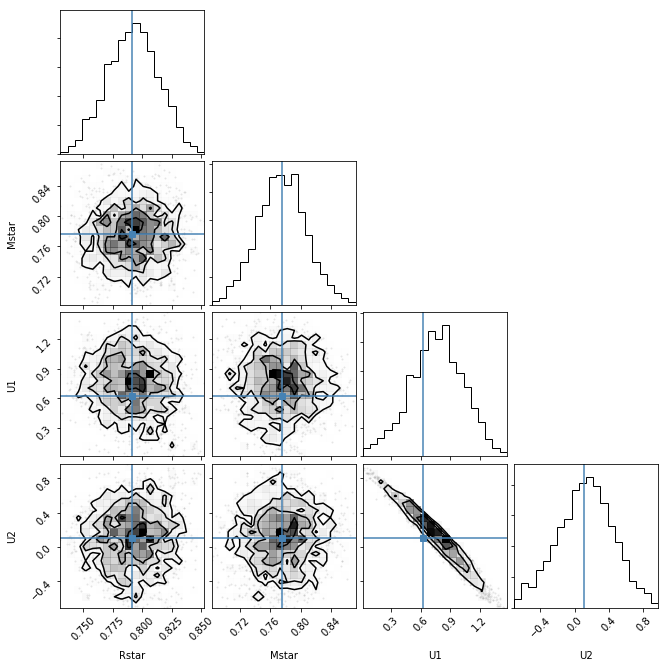

In [54]:
data = np.stack([RSTAR, MSTAR, U1, U2]).swapaxes(0,1)
labels = ['Rstar', 'Mstar', 'U1', 'U2']

if MISSION == "Simulated":
    truths = [Rs_true, Ms_true, u1_true, u2_true]
else:
    truths = None

fig = corner.corner(data, labels=labels, truths=truths)

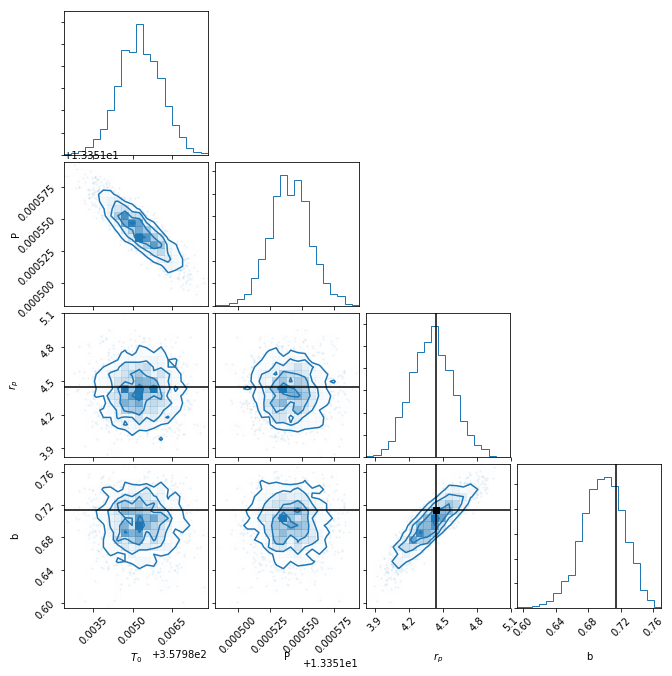

In [55]:
for npl in range(NPL):
    data = np.stack([T0[:,npl], P[:,npl], RP[:,npl], B[:,npl]]).swapaxes(0,1)
    labels = ['$T_0$', 'P', '$r_p$', 'b']
    
    
    if MISSION == "Simulated":
        truths = [None, None, rp_true[npl], b_true[npl]]
    else:
        truths = None


    fig = corner.corner(data, labels=labels, truths=truths, color='C{0}'.format(npl), truth_color="k")

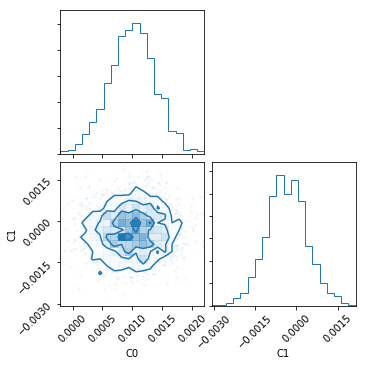

In [56]:
for npl in range(NPL):
    try:
        data = np.stack([C0[:,npl], C1[:,npl], C2[:,npl], C3[:,npl]]).swapaxes(0,1)
        labels = ['C0', 'C1', 'C2', 'C3']

        fig = corner.corner(data, labels=labels, color='C{0}'.format(npl))
        
    except:
        try:
            data = np.stack([C0[:,npl], C1[:,npl], C2[:,npl]]).swapaxes(0,1)
            labels = ['C0', 'C1', 'C2']

            fig = corner.corner(data, labels=labels, color='C{0}'.format(npl))
        
        except:
            try:
                data = np.stack([C0[:,npl], C1[:,npl]]).swapaxes(0,1)
                labels = ['C0', 'C1']

                fig = corner.corner(data, labels=labels, color='C{0}'.format(npl))

            except:
                pass

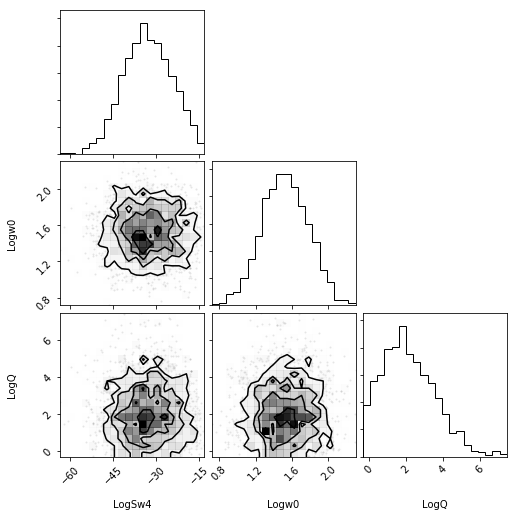

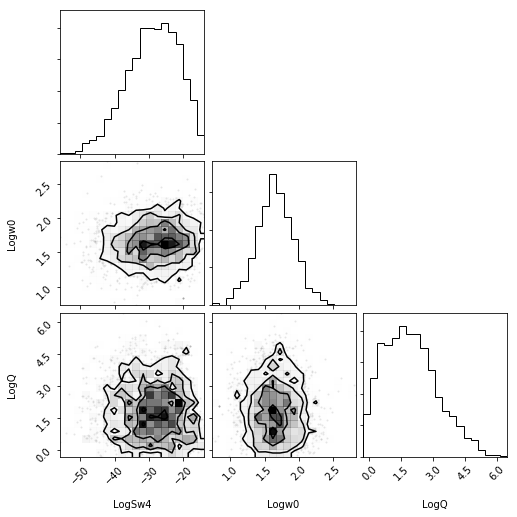

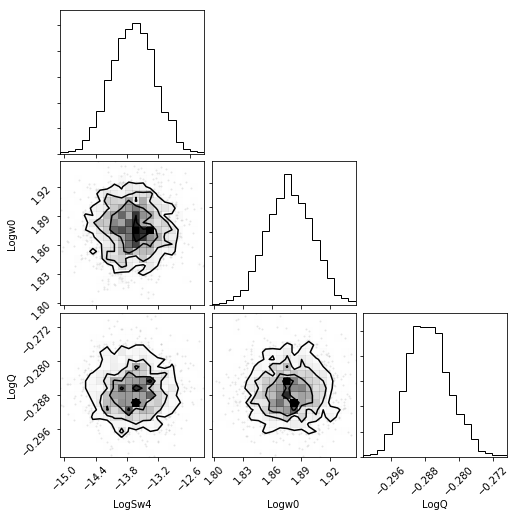

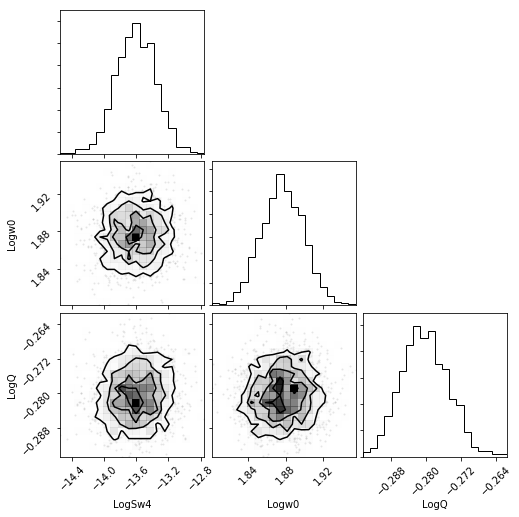

In [57]:
for z in range(4):
    data  = []
    labels = []

    if np.sum(LOGSW4[:,z] != 0):
        data.append(LOGSW4[:,z])
        labels.append('LogSw4')
        
    if np.sum(LOGW0[:,z] != 0):
        data.append(LOGW0[:,z])
        labels.append('Logw0')    
    
    if np.sum(LOGQ[:,z] != 0):
        data.append(LOGQ[:,z])
        labels.append('LogQ')
        
    
    try:
        data = np.stack(data).swapaxes(0,1)
        fig = corner.corner(data, labels=labels)
        
    except:
        pass

# Get transit times, linear ephemeris and O-C

In [ ]:
if MISSION == "Simulated":
    true_inds = []
    true_tts  = []
    true_omc  = []
    
    for npl in range(NPL):
        data_in = np.loadtxt(TRUE_TTV_DIR + TARGET + '_{:02d}'.format(npl) + '_sim_ttvs.txt')
        
        inds, tts = np.atleast_2d(data_in).swapaxes(0,1)
        
        ephem = poly.polyval(inds, poly.polyfit(inds, tts, 1))
        
        true_inds.append(inds)
        true_tts.append(tts)
        true_omc.append((tts-ephem)*24*60)

In [ ]:
epochs = np.zeros(NPL)
periods = np.zeros(NPL)

transit_times = []
ephemeris = []
transit_inds = []

for npl in range(NPL):   
    transit_times.append(np.median(TTS[npl], axis=0))
    
    t0  = np.median(T0[:,npl])
    per = np.median(P[:,npl])
    tts = transit_times[npl]
    
    tinds = np.array(np.floor((tts - t0 + per/2) / per), dtype='int')
    
    epochs[npl] = t0
    periods[npl] = per
    ephemeris.append(t0 + per*tinds)
    transit_inds.append(tinds)

In [ ]:
fig, axes = plt.subplots(NPL, figsize=(12,8))

for npl in range(NPL):    
    xtime = transit_times[npl]
    yomc  = (transit_times[npl]-ephemeris[npl])*24*60
    
    axes[npl].plot(xtime, yomc, "o", color='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
    
    if MISSION == "Simulated":
        axes[npl].plot(true_tts[npl], true_omc[npl], c="grey")
    
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20) 

plt.savefig(FIGURE_DIR + TARGET + '_ttvs_shape.pdf', bbox_inches='tight')
plt.show()